<a href="https://colab.research.google.com/github/yifeiw701/todo_app/blob/master/ML_MLP%26CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!git clone https://github.com/zalandoresearch/fashion-mnist.git

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 20.19 MiB/s, done.
Resolving deltas: 100% (444/444), done.


In [ ]:
import sys
sys.path.append("./fashion-mnist/utils")
import os
os.listdir()
os.chdir("./fashion-mnist/utils")

In [ ]:
import numpy as np
import mnist_reader
import matplotlib.pyplot as plt
from typing import List
from tqdm import tqdm
from sklearn.utils import shuffle
import math as Math
from scipy.optimize import check_grad
import tensorflow as tf
import keras

# Task 1: Acquire Data

In [ ]:
X_train_raw, y_train = mnist_reader.load_mnist('/content/fashion-mnist/data/fashion', kind='train')
X_test_raw, y_test = mnist_reader.load_mnist('/content/fashion-mnist/data/fashion', kind='t10k')
y_train_raw = y_train

Data Analysis

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(0, len(class_names)):
    occurence = len(y_train[y_train == i])
    print(f"Class {class_names[i]} contains {occurence} training examples.")  

Class T-shirt/top contains 6000 training examples.
Class Trouser contains 6000 training examples.
Class Pullover contains 6000 training examples.
Class Dress contains 6000 training examples.
Class Coat contains 6000 training examples.
Class Sandal contains 6000 training examples.
Class Shirt contains 6000 training examples.
Class Sneaker contains 6000 training examples.
Class Bag contains 6000 training examples.
Class Ankle boot contains 6000 training examples.


Data dimensions checks

In [ ]:
np.info(X_train_raw), np.info(y_train)

class:  ndarray
shape:  (60000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x24344030
byteorder:  little
byteswap:  False
type: uint8
class:  ndarray
shape:  (60000,)
strides:  (1,)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x9588028
byteorder:  little
byteswap:  False
type: uint8


(None, None)

In [ ]:
np.info(X_test_raw), np.info(y_test)

class:  ndarray
shape:  (10000, 784)
strides:  (784, 1)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x3f4aa030
byteorder:  little
byteswap:  False
type: uint8
class:  ndarray
shape:  (10000,)
strides:  (1,)
itemsize:  1
aligned:  True
contiguous:  True
fortran:  True
data pointer: 0x7c2c028
byteorder:  little
byteswap:  False
type: uint8


(None, None)

Normalizing the data

In [ ]:
def normalize_data(X_train_raw, X_test_raw):
  return X_train_raw / 255.0, X_test_raw / 255.0
  # return X_train_raw / np.std(X_train_raw, axis = 0), X_test_raw / np.std(X_test_raw, axis = 0)

In [ ]:
X_train, X_test = normalize_data(X_train_raw, X_test_raw)
X_train, y_train = shuffle(X_train, y_train)

# Task 2: Implement an MLP to classify image data


Neural Net Layer

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None
        
    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

Linear Layer

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.sqrt(2/input_size) * np.random.randn(output_size, input_size)
        self.b = np.sqrt(2/input_size) * np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        self.penalty = np.sum(self.w**2)
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

    def check_gradient(self):
        pass

ReLu Layer

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

TanH Layer

In [ ]:
class TanHLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.gradient = 1 - (np.tanh(x) * np.tanh(x))
        return np.tanh(x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

Leaky ReLu

In [ ]:
class LeakyReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.alpha = 0.01
        
    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, self.alpha)
        return np.where(x > 0, x, x *  self.alpha)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

Softmax Output Layer

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        # exps = np.exp(x)
        # probs = exps / np.sum(exps, axis=-1)[:, None]
        # self.cur_probs = probs
        exps = np.exp(x - np.max(x,axis=-1, keepdims=True))
        np.clip(exps, 0.0001, 0.9999, out=exps)
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

MLP 

In [ ]:
class MLP:
  def __init__(self, activation, L, H, n_features, n_data_class):
        assert L == len(H)
        layers = []

        if(L == 0):
          layers.append(LinearLayer(n_features, n_data_class))
          layers.append(SoftmaxOutputLayer())
          print('Linear Layer:' + str(n_features) + " x " + str(n_data_class))
          print('Softmax Layer')
          self.layers = layers
          self.losses = []
          self.training_accuracy = []
          return

        for i in range(L):
          if(i == 0) :
            layers.append(LinearLayer(n_features, H[i]))
            print('Linear Layer:' + str(n_features) + " x " + str(H[i]))
          else: 
            layers.append(LinearLayer(H[i-1], H[i]))
            print('Linear Layer:' + str(H[i-1]) + " x " + str(H[i]))

          if(activation == "RELU"):
            layers.append(ReLULayer())
            print('RELU Layer')
          elif(activation == "TANH"):
            layers.append(TanHLayer())
            print('TANH Layer')
          elif(activation == "LRELU"):
            layers.append(LeakyReLULayer())
            print('LRELU Layer')
          
        
        layers.append(LinearLayer(H[len(H) - 1], n_data_class))
        layers.append(SoftmaxOutputLayer())
        print('Linear Layer:' + str(H[i-1]) + " x " + str(n_data_class))
        print('Softmax Layer')

        self.layers = layers
        self.losses = []
        self.training_accuracy = []

  def fit_mini_batch(self, data_x, data_y, optimizer, n_data_class, batch_size, hyper_epoch):
    steps = Math.floor(data_x.shape[0] / batch_size )
    for _ in range(hyper_epoch) :
      for i in tqdm(range(1, steps)):
          data_i = data_x[batch_size * (i-1) :batch_size*i]
          data_j = data_y[batch_size * (i-1) :batch_size*i]
          labels = np.eye(n_data_class)[np.array(data_y[batch_size * (i-1) :batch_size*i])]
          predictions = self.forward(data_i)
          self.training_accuracy.append(evalute_acc(predictions, data_j))
          loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
          self.losses.append(loss)
          self.backward(labels)
          optimizer.step()
    plt.plot(self.losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.show()

  def fit_mini_batch_regularized(self, data_x, data_y, optimizer, n_data_class, batch_size, lb,  hyper_epoch, steps = 0):
    if(steps == 0):
      steps = Math.floor(data_x.shape[0] / batch_size)
    for _ in range(hyper_epoch) :
      for i in tqdm(range(1,steps)):   
          data_i = data_x[batch_size * (i-1) :batch_size*i]
          data_j = data_y[batch_size * (i-1) :batch_size*i]
          labels = np.eye(n_data_class)[np.array(data_y[batch_size * (i-1) :batch_size*i])]
          predictions = self.forward(data_i)
          self.training_accuracy.append(evalute_acc(predictions, data_j))
          penalty = 0
          for layer in self.layers:
            if hasattr(layer, 'penalty'):
              penalty += layer.penalty
          loss = -(labels * np.log(predictions)).sum(axis=-1).mean() + ((lb/2.0) * lb * penalty)
          self.losses.append(loss)
          self.backward(labels)
          optimizer.step()
    plt.plot(self.losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.show()

  def predict(self, data_x):
    return self.forward(data_x)

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, target):
    for layer in self.layers[::-1]:
      target = layer.backward(target)


Network Optimization

We can have different implementation of Gradient Descent integrated in the optimizer interface.

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

class GradientDescentOptimizerRegularized(Optimizer):
    def __init__(self, net: MLP, lr: float, lb:float):
        super().__init__(net)
        self.lr = lr
        self.lb = lb

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * ((self.lb * p) + g.mean(axis=0))  

Model Evaluation Accuracy

In [ ]:
def evalute_acc(y_pred, y_true):

  y_pred_list = []

  for i in range(len(y_pred)):
    y_pred_list.append(np.argmax(y_pred[i]))

  sum = 0

  for i in range(len(y_pred_list)):
    if(y_pred_list[i] == y_true[i]):
      sum = sum + 1

  return sum / len(y_true)

##GRADIENT CHECK

In [ ]:
EPSILON = 1e-5
BATCH_SIZE = 16
n_features = 784
n_data_class = 10

def gradient_check(mlp, x, y, n_data_class, epsilon):

  ## GET CALCULATED GRADIENTS
  labels = np.eye(n_data_class)[np.array(y)]
  predictions = mlp.forward(x)
  loss_initial = -(labels * np.log(predictions)).sum(axis=-1).mean()
  mlp.backward(labels)

  J_true = []

  for layer in mlp.layers:
    if hasattr(layer, 'w'):
      J_true.append(layer.gradient[0].mean(axis=0))
      
  J_small = []
  labels = np.eye(n_data_class)[np.array(y)]

  for layer in mlp.layers:
    if hasattr(layer, 'w'):
      W_initial = layer.w
      jacobian = np.zeros(W_initial.shape)
      for i in range(W_initial.shape[0]):
        for j in range(W_initial.shape[1]):
          
          layer_true = layer.w[i,j]

          layer.w[i,j] = layer.w[i,j] + epsilon
          predictions = mlp.forward(x)
          loss_bigger = -(labels * np.log(predictions)).sum(axis=-1).mean()
          layer.w[i,j] = layer_true

          layer.w[i,j] = layer.w[i,j] - epsilon
          predictions = mlp.forward(x)
          loss_smaller = -(labels * np.log(predictions)).sum(axis=-1).mean()
          layer.w[i,j] = layer_true

          jacobian[i,j] = (loss_bigger - loss_smaller) / (2*epsilon)

      J_small.append(jacobian)

  return [J_true, J_small]

mlp_grad = MLP("RELU", 2, [128, 128], n_features, n_data_class)
data_x = X_train[0:BATCH_SIZE]
data_y = y_train[0:BATCH_SIZE]

J = gradient_check(mlp_grad, data_x, data_y, n_data_class, EPSILON)

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


All the numerical gradients here should be very small.

In [ ]:
J_true = J[0]
J_small = J[1]
check = True

for i in range(len(J_true)):
  sub = np.subtract(J_true[i], J_small[i])
  print(np.max(np.abs(sub)))
  if(np.max(np.abs(sub)) > 1e-8):
    print('Gradients are bad')
    check = False
    break;

if(check):
  print('Gradients are Good')

5.15060048647889e-11
4.568671829741078e-11
4.123596082650227e-11
Gradients are Good


# Task 3: EXPERIMENTS

##EXPERIMENT #1

Linear Layer:784 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:03<00:00, 558.35it/s]


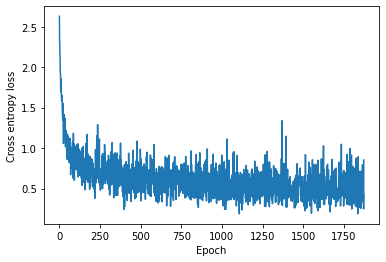

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:35<00:00, 52.68it/s]


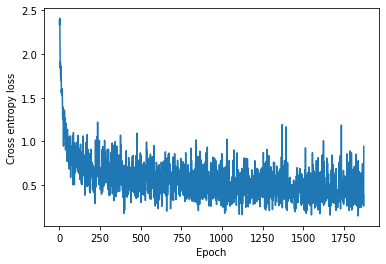

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:40<00:00, 45.91it/s]


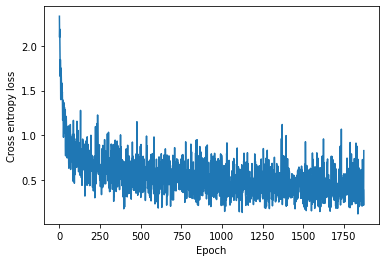

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 32
HYPEREPOCH = 1

# NON REGULARIZED MODEL 0 Hidden Layers
mlp0 = MLP("RELU", 0, [], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp0, 0.05)
mlp0.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

## NON REGULARIZED MODEL 1 Hidden Layers
mlp1 = MLP("RELU", 1, [128], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp1, 0.05)
mlp1.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

## NON REGULARIZED MODEL 2 Hidden Layers
mlp2 = MLP("RELU", 2, [128, 128], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp2, 0.05)
mlp2.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

In [ ]:
predictions = mlp0.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (0 Layers):')
print(accuracy)

predictions = mlp0.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (0 Layers):')
print(accuracy)


predictions = mlp1.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (1 Layers):')
print(accuracy)

predictions = mlp1.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (1 Layers):')
print(accuracy)

predictions = mlp2.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (2 Layers):')
print(accuracy)

predictions = mlp2.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (2 Layers):')
print(accuracy)

Training Accuracy (0 Layers):
0.8311
Testing Accuracy (0 Layers):
0.8169
Training Accuracy (1 Layers):
0.8454833333333334
Testing Accuracy (1 Layers):
0.8277
Training Accuracy (2 Layers):
0.84655
Testing Accuracy (2 Layers):
0.8298


Training Accuracy Plots for MLP0, MLP1, MLP2

Text(0.5, 1.0, 'Training Accuracy over the Epochs')

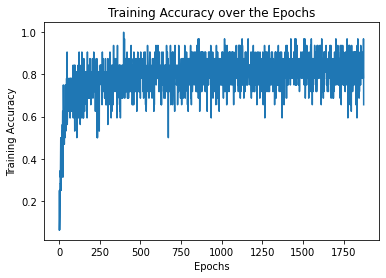

In [ ]:
steps = Math.floor(X_train.shape[0] / BATCH_SIZE)
epoch = list(range(1, steps))

plt.plot(epoch, mlp0.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over the Epochs")

Text(0.5, 1.0, 'Training Accuracy of MLP1 over the Epochs')

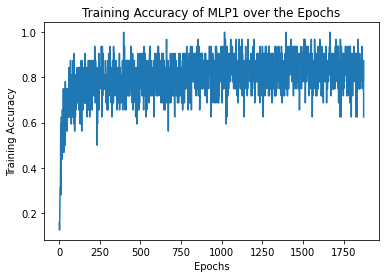

In [ ]:
plt.plot(epoch, mlp1.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy of MLP1 over the Epochs")

Text(0.5, 1.0, 'Training Accuracy of MLP2 over the Epochs')

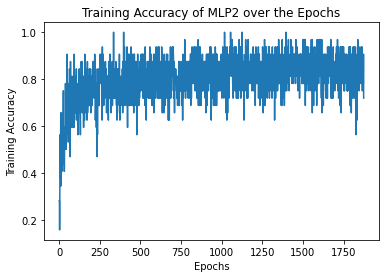

In [ ]:
plt.plot(epoch, mlp2.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy of MLP2 over the Epochs")

### Experiment 1.1: Effect of Batch Size

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:42<00:00, 43.88it/s]


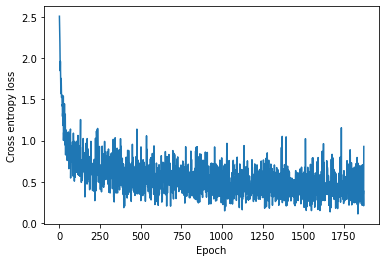

Testing Accuracy with batch size of 32:0.8347
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 936/936 [00:38<00:00, 24.17it/s]


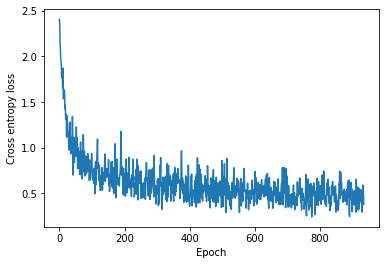

Testing Accuracy with batch size of 64:0.8101
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [00:37<00:00, 12.40it/s]


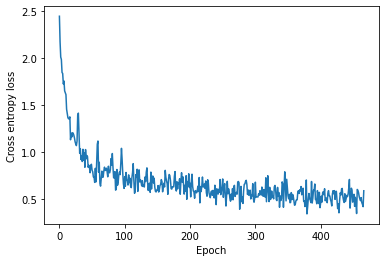

Testing Accuracy with batch size of 128:0.7722
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 233/233 [00:37<00:00,  6.30it/s]


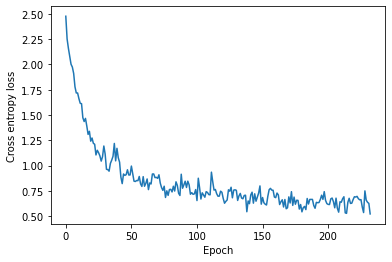

Testing Accuracy with batch size of 256:0.7978
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 116/116 [00:33<00:00,  3.47it/s]


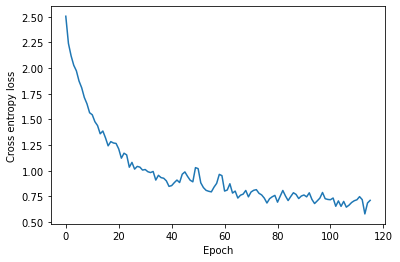

Testing Accuracy with batch size of 512:0.7175
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 57/57 [00:27<00:00,  2.06it/s]


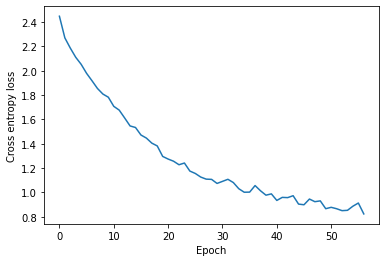

Testing Accuracy with batch size of 1024:0.6981


In [ ]:
batch_size_experiments = [32, 64, 128, 256, 512, 1024]
learning_rate_experiment = 0.05
results = []

## NON REGULARIZED MODEL 2 Hidden Layers
for batch_size in batch_size_experiments:
    mlp = MLP("RELU", 2, [128, 128], n_features, n_data_class)
    optimizer = GradientDescentOptimizer(mlp, learning_rate_experiment)
    mlp.fit_mini_batch(X_train, y_train, optimizer,n_data_class, batch_size, HYPEREPOCH)

    predictions = mlp.predict(X_test)
    accuracy = evalute_acc(predictions, y_test)
    results.append(accuracy)
    print(f'Testing Accuracy with batch size of {batch_size}:{accuracy}')

Text(0.5, 1.0, 'Test Accuracy according to batch size.')

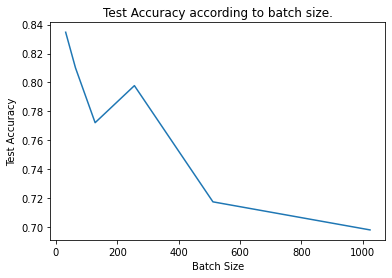

In [ ]:
plt.plot(batch_size_experiments, results)
plt.xlabel("Batch Size")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy according to batch size.")

##EXPERIMENT #2

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 32
HYPEREPOCH = 1

## NON REGULARIZED MODEL 2 Hidden Layers (TANH)
mlp3 = MLP("TANH", 2, [128, 128], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp3, 0.05)
mlp3.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

## NON REGULARIZED MODEL 2 Hidden Layers (LRELU)
mlp4 = MLP("LRELU", 2, [128, 128], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp4, 0.05)
mlp4.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

In [ ]:
predictions = mlp3.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (2 Layers TANH):')
print(accuracy)

predictions = mlp3.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (2 Layers TANH):')
print(accuracy)

predictions = mlp4.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (2 Layers LRELU):')
print(accuracy)

predictions = mlp4.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (2 Layers LRELU):')
print(accuracy)

Training Accuracy (2 Layers TANH):
0.8532666666666666
Testing Accuracy (2 Layers TANH):
0.8365
Training Accuracy (2 Layers LRELU):
0.8525166666666667
Testing Accuracy (2 Layers LRELU):
0.8349


Training Accuracy Plots

In [ ]:
steps = Math.floor(X_train.shape[0] / BATCH_SIZE)
epoch = list(range(1, steps))

plt.plot(epoch, mlp4.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over the Epochs")

In [ ]:
plt.plot(epoch, mlp3.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over the Epochs")

##EXPERIMENT #3

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:46<00:00, 40.00it/s]


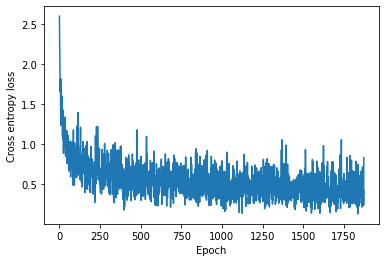

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 32
HYPEREPOCH = 1
LAMBDA = 0.001

## REGULARIZED MODEL 2 Hidden Layers
mlp5 = MLP("RELU", 2, [128, 128], n_features, n_data_class)
optimizer = GradientDescentOptimizerRegularized(mlp5, 0.05, LAMBDA)
mlp5.fit_mini_batch_regularized(X_train, y_train, optimizer, n_data_class, BATCH_SIZE, LAMBDA, HYPEREPOCH)

In [ ]:
predictions = mlp5.predict(X_train)
accuracy = evalute_acc(predictions, y_train)
print('Training Accuracy (2 Layers):')
print(accuracy)

predictions = mlp5.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print('Testing Accuracy (2 Layers):')
print(accuracy)

Training Accuracy (2 Layers):
0.85115
Testing Accuracy (2 Layers):
0.8327


### Experiment 3.1: Effect of LAMBDA

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:43<00:00, 43.42it/s]


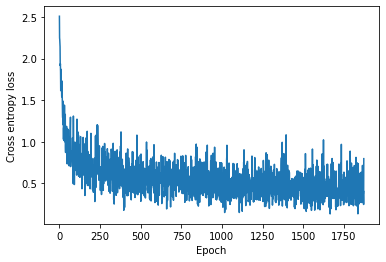

Testing Accuracy with lambda = 0.001: 0.8347
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:42<00:00, 44.18it/s]


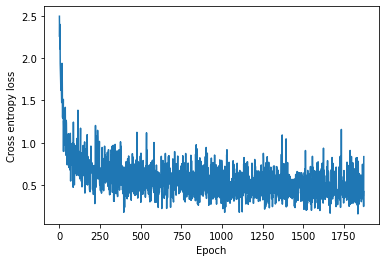

Testing Accuracy with lambda = 0.005: 0.8271
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:42<00:00, 43.60it/s]


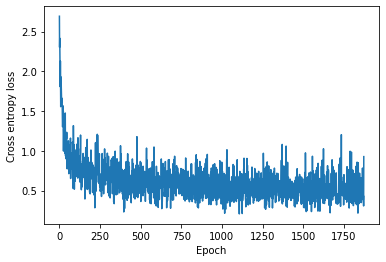

Testing Accuracy with lambda = 0.01: 0.8089
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:43<00:00, 43.30it/s]


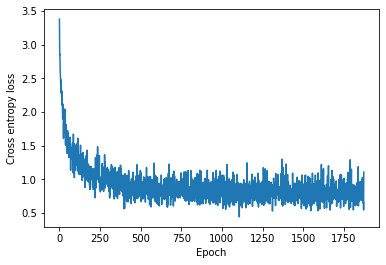

Testing Accuracy with lambda = 0.05: 0.7368
Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 1874/1874 [00:42<00:00, 44.54it/s]


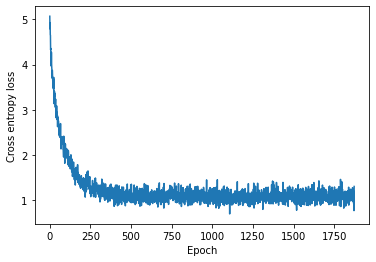

Testing Accuracy with lambda = 0.1: 0.6304


In [ ]:
LAMBDA_experiments = [0.001, 0.005, 0.01, 0.05, 0.1]
results = []
for lambda_values in LAMBDA_experiments:
    mlp = MLP("RELU", 2, [128, 128], n_features, n_data_class)
    optimizer = GradientDescentOptimizerRegularized(mlp, 0.05, lambda_values)
    mlp.fit_mini_batch_regularized(X_train, y_train, optimizer, n_data_class, BATCH_SIZE, lambda_values, HYPEREPOCH, steps = 0)

    predictions = mlp.predict(X_test)
    accuracy = evalute_acc(predictions, y_test)
    print(f'Testing Accuracy with lambda = {lambda_values}: {accuracy}')
    results.append(accuracy)

Text(0.5, 1.0, 'Effect of Lambda over Test Accuracy')

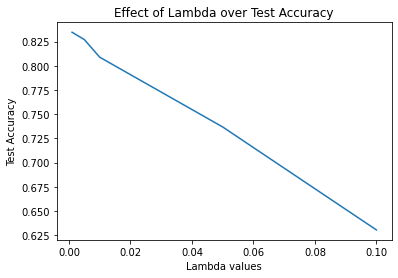

In [ ]:
plt.plot(LAMBDA_experiments, results)
plt.xlabel("Lambda values")
plt.ylabel("Test Accuracy")
plt.title("Effect of Lambda over Test Accuracy")

##EXPERIMENT #4

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

mlp4 = MLP("RELU", 2, [128, 128], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp4, 0.005)
mlp4.fit_mini_batch(X_train_raw, y_train_raw, optimizer, n_data_class, BATCH_SIZE, HYPEREPOCH)

Linear Layer:784 x 128
RELU Layer
Linear Layer:128 x 128
RELU Layer
Linear Layer:128 x 10
Softmax Layer


NameError: ignored

In [ ]:
predictions = mlp4.predict(X_test_raw)
accuracy = evalute_acc(predictions, y_test)
print(f'Testing Accuracy: {accuracy}')

Testing Accuracy: 0.4174


Training Accuracy Plot

In [ ]:
steps = Math.floor(X_train_raw.shape[0] / BATCH_SIZE)
epoch = list(range(1, steps))

plt.plot(epoch, mlp0.training_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy over the Epochs")

##EXPERIMENT #5

In [ ]:
(X_train_raw, y_train),(X_test_raw, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train_raw / 255.0
X_test = X_test_raw / 255.0

In [ ]:
ConvNet_model = keras.models.Sequential(
    [
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 3,
            strides = (1,1),
            padding = 'valid',
            activation = 'relu',
            input_shape = [28,28,1]   
        ),
        
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 3,
            strides = (2,2),
            padding = 'valid',
            activation = 'relu',
            input_shape = [28,28,1]   
        ),
   
        keras.layers.Flatten(),       
        keras.layers.Dense(units = 128, activation = 'relu'),       
        keras.layers.Dense(units = 128, activation = 'relu'),
        keras.layers.Dense(units = 10, activation = 'softmax') 
    ]
)
ConvNet_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
ConvNet_model.fit(X_train, y_train)

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4096 - accuracy: 0.8512


In [ ]:
ConvNet_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.3448 - accuracy: 0.8721


[0.34482675790786743, 0.8720999956130981]

## EXPERIMENT #6

### Experiment 6.1: Effect of increasing hidden layers at different learning rates on the test accuracy.

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [00:46<00:00,  9.95it/s]


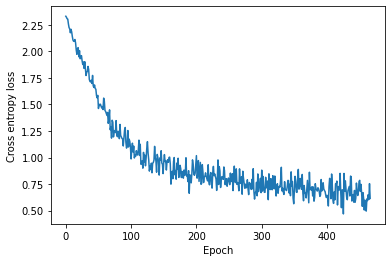

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [00:42<00:00, 10.94it/s]


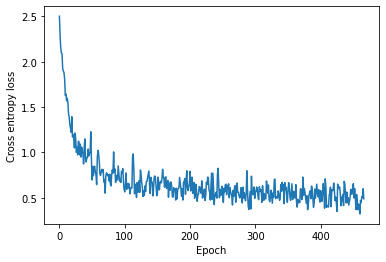

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [00:43<00:00, 10.61it/s]


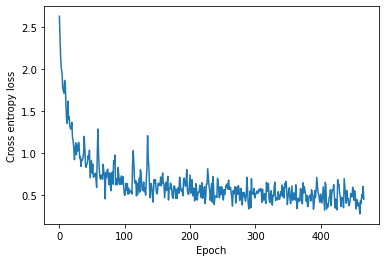

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [01:00<00:00,  7.73it/s]


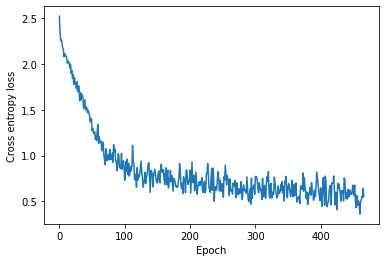

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [01:01<00:00,  7.58it/s]


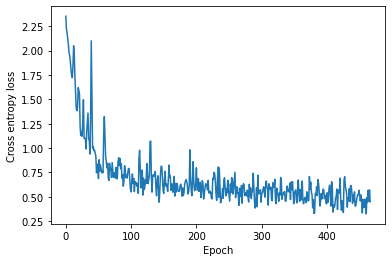

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [00:59<00:00,  7.83it/s]


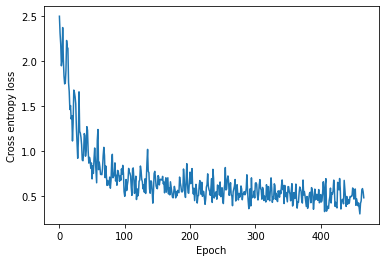

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [01:20<00:00,  5.81it/s]


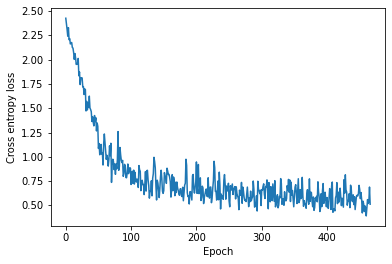

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [01:18<00:00,  5.98it/s]


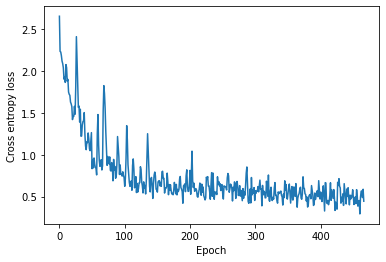

Linear Layer:784 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 128
LRELU Layer
Linear Layer:128 x 10
Softmax Layer


100%|██████████| 467/467 [01:19<00:00,  5.86it/s]


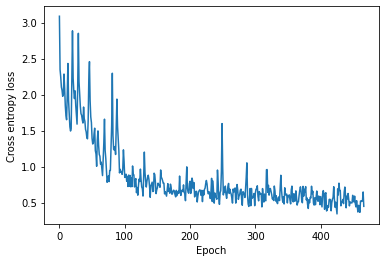

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

hidden_layers_experiments = [3,6,9]
learning_rate_experiments = [0.01, 0.05, 0.1]
results = []

for number_hidden_layers in hidden_layers_experiments:
    for learning_rate in learning_rate_experiments:
      hidden_layers_size = np.full(number_hidden_layers, BATCH_SIZE)
      mlp = MLP("LRELU", number_hidden_layers, hidden_layers_size, n_features, n_data_class)
      optimizer = GradientDescentOptimizer(mlp, learning_rate)
      mlp.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

      predictions = mlp.predict(X_test)
      accuracy = evalute_acc(predictions, y_test)
      results.append((number_hidden_layers, accuracy, learning_rate))

In [ ]:
results

[(3, 0.7728, 0.01),
 (3, 0.8133, 0.05),
 (3, 0.8243, 0.1),
 (6, 0.791, 0.01),
 (6, 0.8128, 0.05),
 (6, 0.8148, 0.1),
 (9, 0.7947, 0.01),
 (9, 0.8188, 0.05),
 (9, 0.8034, 0.1)]

### Experiment 6.2: Effect of increasing depth at a constant learning rate on the test accuracy.

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

number_hidden_layers = 3
layer_width_experiments = [32, 64, 128, 256]
results = []
learning_rate = 0.1

for width in layer_width_experiments:
    hidden_layers_size = np.full(number_hidden_layers, width)
    mlp = MLP("LRELU", number_hidden_layers, hidden_layers_size, n_features, n_data_class)
    optimizer = GradientDescentOptimizer(mlp, learning_rate)
    mlp.fit_mini_batch(X_train, y_train, optimizer, n_data_class, BATCH_SIZE, HYPEREPOCH)

    predictions = mlp.predict(X_test)
    accuracy = evalute_acc(predictions, y_test)
    results.append((number_hidden_layers, width, learning_rate, accuracy))

In [ ]:
results

[(3, 32, 0.1, 0.8086),
 (3, 64, 0.1, 0.8248),
 (3, 128, 0.1, 0.8287),
 (3, 256, 0.1, 0.8335)]

### Experiment 6.3: Fine-Tuning the learning rate for an architecture of 3 hidden layers and 256 hidden units.

Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:46<00:00,  4.38it/s]


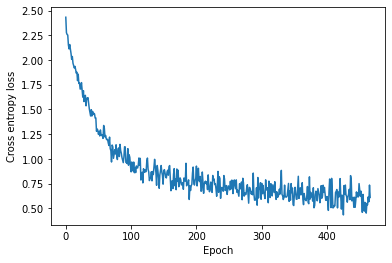

Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:48<00:00,  4.29it/s]


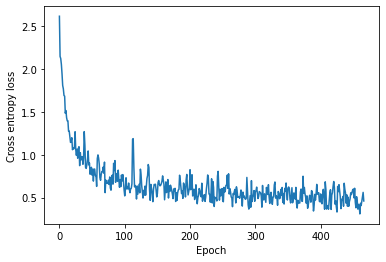

Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:47<00:00,  4.35it/s]


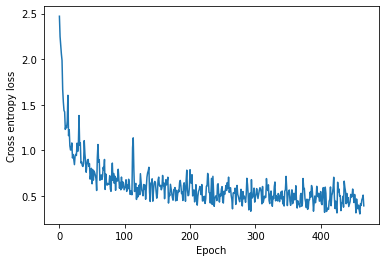

Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:48<00:00,  4.29it/s]


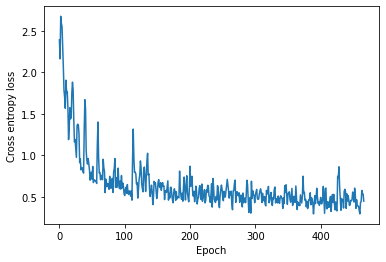

Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


  1%|          | 5/467 [00:01<01:42,  4.53it/s]<ipython-input-15-be50e9d051a3>:7: RuntimeWarning: overflow encountered in exp
  exps = np.exp(x)
<ipython-input-15-be50e9d051a3>:8: RuntimeWarning: invalid value encountered in true_divide
  probs = exps / np.sum(exps, axis=-1)[:, None]
<ipython-input-16-52980e54e1c9>:50: RuntimeWarning: divide by zero encountered in log
  loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
<ipython-input-16-52980e54e1c9>:50: RuntimeWarning: invalid value encountered in multiply
  loss = -(labels * np.log(predictions)).sum(axis=-1).mean()
100%|██████████| 467/467 [01:48<00:00,  4.30it/s]


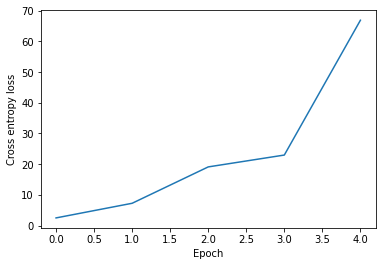

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

number_hidden_layers = 3
layer_width = 256
results = []
learning_rates = [0.01, 0.05, 0.1, 0.3, 0.7]

for learning_rate in learning_rates:
    hidden_layers_size = np.full(number_hidden_layers, layer_width)
    mlp = MLP("LRELU", number_hidden_layers, hidden_layers_size, n_features, n_data_class)
    optimizer = GradientDescentOptimizer(mlp, learning_rate)
    mlp.fit_mini_batch(X_train, y_train, optimizer, n_data_class, BATCH_SIZE, HYPEREPOCH)

    predictions = mlp.predict(X_test)
    accuracy = evalute_acc(predictions, y_test)
    results.append((number_hidden_layers, layer_width, learning_rate, accuracy))

In [ ]:
results

[(3, 256, 0.01, 0.7929),
 (3, 256, 0.05, 0.8232),
 (3, 256, 0.1, 0.8286),
 (3, 256, 0.3, 0.8292),
 (3, 256, 0.7, 0.1)]

### Experiment 6.4: Effect of activation functions

Linear Layer:784 x 256
RELU Layer
Linear Layer:256 x 256
RELU Layer
Linear Layer:256 x 256
RELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:48<00:00,  4.30it/s]


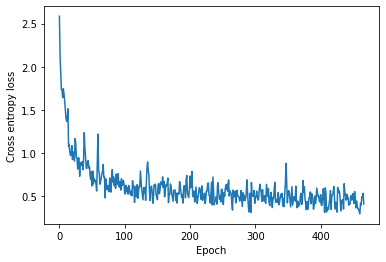

('RELU', 0.8271)
Linear Layer:784 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 256
LRELU Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:47<00:00,  4.34it/s]


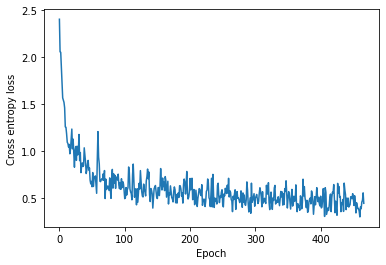

('LRELU', 0.8305)
Linear Layer:784 x 256
TANH Layer
Linear Layer:256 x 256
TANH Layer
Linear Layer:256 x 256
TANH Layer
Linear Layer:256 x 10
Softmax Layer


100%|██████████| 467/467 [01:53<00:00,  4.13it/s]


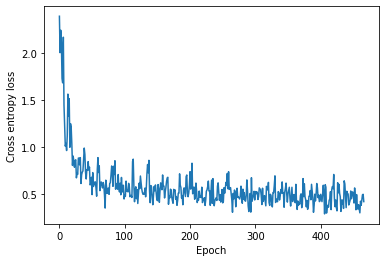

('TANH', 0.8213)


In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

act_fns = ["RELU", "LRELU", "TANH"]
results = []


for act_fn in act_fns:
  mlp = MLP(act_fn, 3, [256, 256, 256], n_features, n_data_class)
  optimizer = GradientDescentOptimizer(mlp, 0.1)
  mlp.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

  predictions = mlp.predict(X_test)
  accuracy = evalute_acc(predictions, y_test)
  print((act_fn, accuracy))

In [ ]:
results

### Experiment 6.5: Accuracy of a wide MLP with 2 hidden layers and 1024 hidden units.

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

mlp = MLP("LRELU", 2, [1024, 1024], n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp, 0.01)
mlp.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

predictions = mlp.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print(accuracy)

### Experiment 6.6: Accuracy of a long MLP with 8 hidden layers and 128 hidden units.

In [ ]:
n_features = 784
n_data_class = 10
BATCH_SIZE = 128
HYPEREPOCH = 1

hidden_layers_size = np.full(8, 128)
mlp = MLP("LRELU", 8, hidden_layers_size, n_features, n_data_class)
optimizer = GradientDescentOptimizer(mlp, 0.01)
mlp.fit_mini_batch(X_train, y_train, optimizer,n_data_class, BATCH_SIZE, HYPEREPOCH)

predictions = mlp.predict(X_test)
accuracy = evalute_acc(predictions, y_test)
print(accuracy)